## Data Import

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
from hmmlearn import hmm
import matplotlib.pyplot as plt
import time
from numpy.linalg import matrix_power
from collections import Counter
from scipy.stats import poisson
from scipy.stats import linregress

#https://archive.ics.uci.edu/ml/datasets/Molecular+Biology+%28Promoter+Gene+Sequences%29
data = Path('p.datas')
promoters = open(data, "r")
d = promoters.readlines()

In [3]:
with open('p.data', 'r') as f:
    # Read the file line by line
    data1 = f.readlines()

In [4]:
sequences = []
# Iterate over the lines and split each line using a comma delimiter
for line in data1:
    # Remove any trailing newline characters
    line = line.rstrip('\n')
    line = line.rstrip('\t')

    # Split the line into a list of values using a comma delimiter
    values = line.split(',')
    val = values[2].strip('\t').upper()
    sequences.append(val)

# Markov Chains

## Analysis

In [5]:
nucleotides = ['A', 'G', 'C', 'T']
total_permuts = []

# Determines total permutations of nucleotides.
# Ex. AAAA, AGCT, CGTA, TCGA, etc.
def permut(nucleotides, curr_permut, length):
    if length == 0:
        total_permuts.append(curr_permut)
    else:
        for n in nucleotides:
            permut(nucleotides, curr_permut + n, length - 1)
            
# Needed for computing probabilties
permut(nucleotides, '', 4)

In [6]:
# This function will calculate the probabilities of the probabilty matrix
def compute_probs(arr_seqs):
    # Define a 4x4 matrix to store the transition counts
    transition_counts = np.zeros((4, 4))

    # Iterate over all permutations of nucleotides the dataset and count transitions
    for a in total_permuts:
        # Iterate over all sequecnes from the dataset
        for seq in arr_seqs:
            curr_nucleotide = seq[0]
            next_nucleotide = seq[1]
            for i in range(len(seq)-1):
                # Count Transitions
                if curr_nucleotide not in nucleotides:
                    curr_nucleotide = seq[i]
                    continue
                if next_nucleotide not in nucleotides:
                    curr_nucleotide = seq[i]
                    next_nucleotide = seq[i+1]
                    continue
                curr_count = nucleotides.index(curr_nucleotide)
                next_count = nucleotides.index(next_nucleotide)
                transition_counts[curr_count][next_count] += 1
                curr_nucleotide = seq[i+1]
                if i < len(seq)-2:
                    next_nucleotide = seq[i+2]
                    
    # Compute the transition probabilities from the counts
    transition_probs = transition_counts / np.sum(transition_counts, axis=1, keepdims=True)
    return transition_probs

In [7]:
# Print the transition probabilities
print("Transition probabilities:")
all_seqs_probs = compute_probs(sequences)
def transpose_probs_to_df(transition_probs):
    transpose_probs = transition_probs.transpose()
    d = {"" : nucleotides, "A" : list(transpose_probs[0]), "G" : list(transpose_probs[1]), 
         "C" : list(transpose_probs[2]), "T" : list(transpose_probs[3])}
    df = pd.DataFrame(d)
    return df
df_all_seqs = transpose_probs_to_df(all_seqs_probs)
display(df_all_seqs)

Transition probabilities:


,,A,G,C,T
0,A,0.281008,0.204134,0.243540,0.271318
1,G,0.282414,0.186289,0.270492,0.260805
2,C,0.252193,0.260234,0.194444,0.293129
3,T,0.232420,0.258045,0.209774,0.299762


In [8]:
# Print the transition probabilities
print("Transition probabilities:")
all_seqs_probs = compute_probs(sequences)
def transpose_probs_to_df(transition_probs):
    transpose_probs = transition_probs.transpose()
    d = {"" : nucleotides, "A" : list(transpose_probs[0]), "G" : list(transpose_probs[1]), 
         "C" : list(transpose_probs[2]), "T" : list(transpose_probs[3])}
    df = pd.DataFrame(d)
    return df
df_all_seqs = transpose_probs_to_df(all_seqs_probs)
display(df_all_seqs)

Transition probabilities:


,,A,G,C,T
0,A,0.281008,0.204134,0.243540,0.271318
1,G,0.282414,0.186289,0.270492,0.260805
2,C,0.252193,0.260234,0.194444,0.293129
3,T,0.232420,0.258045,0.209774,0.299762


In [9]:
# Positive Model means it is a promoter sequence
promoters = sequences[:53]
promoter_probs = compute_probs(promoters)
display_promoter_probs = transpose_probs_to_df(promoter_probs)
display(display_promoter_probs)

,,A,G,C,T
0,A,0.337772,0.158596,0.215496,0.288136
1,G,0.235195,0.174281,0.292724,0.297800
2,C,0.251135,0.249622,0.225416,0.273828
3,T,0.268539,0.221348,0.176404,0.333708


In [10]:
# Negative Model means it is not a promoter sequence
neg_promoters = sequences[53:]
neg_promoter_probs = compute_probs(neg_promoters)
display_neg_promoter_probs = transpose_probs_to_df(neg_promoter_probs)
display(display_neg_promoter_probs)

,,A,G,C,T
0,A,0.216066,0.256233,0.275623,0.252078
1,G,0.319574,0.195739,0.252996,0.231691
2,C,0.253182,0.270156,0.165488,0.311174
3,T,0.191624,0.299492,0.247462,0.261421


#### Log-Odds Ratio with Respect to Model Building: Measure of How Well the Model Predicts the Data
$S(x) = \log \left( \frac{P(x|\text{model}^+)}{P(x|\text{model}^-)} \right) = \sum_{i=1}^{L} \log \left( \frac{a^+_{(x_{i-1})(x_i)}}{a^-_{(x_{i-1})(x_i)}} \right)$

In [11]:
# Log-odds model to predict the if the model is deviates from the standard model
S = 0
index1 = 0
index2 = 0

for i in promoter_probs:
    while index1 < 4:
        for j in neg_promoter_probs:
            while index2 < 4:
                S += np.log( promoter_probs[index1][index2]/neg_promoter_probs[index1][index2] )
                index2 += 1
        index1 += 1
print("The log-odds ratio of the model is", round(S, 3), "which implies both models predict a normal genome.")

The log-odds ratio of the model is -0.145 which implies both models predict a normal genome.


## Gambler's Ruin Problem in the Perspective of Gene Sequences
#### Consider an equilibrium reaction between methylating proteins and RNA polmerase proteins such that RNA polymerase begins transcription on the promoter region of a DNA strand and methylating proteins stop transcription. Methylating proteins have one binding site, but if it binds to the promoter region, the rate of another protein methylating the promoter region is 1. RNA polymerase competes with the binding site of the promoter such that it has a 50% chance of knocking off a methylating protein and binding. Once there are 5 methylating proteins binded to the promoter region, no RNA polymerase can bind, but if there is only RNA polymerase binded to the promoter region, then no more methylating proteins will be able to bind. 
<br> 1. Describe this problem as a Markov chain using the methylating proteins. 
<br>2. What are the states? 
<br>3. Find the probability matrix.

#### Let $X_n$ be defined as a Markov Chain such that n represents the number of methylating proteins.
#### $X_n$ = {1, 2, 3, 4, 5}
#### The states are RNA polymerase binding (-1) or the methylating protein binding (+1).

In [12]:
p00 = 1
p01 = p02 = p03 = p04 = p05 = 0
p10 = p12 = 0.5
p11 = p13 = p14 = p15 = 0
p21 = p23 = 0.5
p20 = p22 = p24 = p25 = 0
p32 = p34 = 0.5
p30 = p31 = p33 = p35 = 0
p43 = p45 = 0.5
p40 = p41 = p42 = p44 = 0
p50 = p51 = p52 = p53 = p54 = 0
p55 = 1
P = np.array([[p00, p01, p02, p03, p04, p05],
                [p10, p11, p12, p13, p14, p15],
                [p20, p21, p22, p23, p24, p25],
                [p30, p31, p32, p33, p34, p35], 
                [p40, p41, p42, p43, p44, p45], 
                [p50, p51, p52, p53, p54, p55]
             ])
P

array([[1. , 0. , 0. , 0. , 0. , 0. ],
       [0.5, 0. , 0.5, 0. , 0. , 0. ],
       [0. , 0.5, 0. , 0.5, 0. , 0. ],
       [0. , 0. , 0.5, 0. , 0.5, 0. ],
       [0. , 0. , 0. , 0.5, 0. , 0.5],
       [0. , 0. , 0. , 0. , 0. , 1. ]])

## Using Chapman Kolmogrov Equation,
### What is the probability that there are 4 methylating proteins consecutively attached to the promoter region after 10 events of competing methylating proteins and or RNA polymerases binding to the promoter region given the first protein to bind was a methylating protein?

In [13]:
from numpy.linalg import matrix_power
P_10_steps = matrix_power(P, 10)
print(P_10_steps)

[[1.         0.         0.         0.         0.         0.        ]
 [0.75195312 0.03320312 0.         0.05371094 0.         0.16113281]
 [0.53710938 0.         0.08691406 0.         0.05371094 0.32226562]
 [0.32226562 0.05371094 0.         0.08691406 0.         0.53710938]
 [0.16113281 0.         0.05371094 0.         0.03320312 0.75195312]
 [0.         0.         0.         0.         0.         1.        ]]


In [14]:
print(f'P¹⁰₁₄ =', P_10_steps[1][3])

P¹⁰₁₄ = 0.0537109375


## Using a Markov Chain {W$_n$, n$\in$$\mathbb{N}$} with state space made up of states not in A and an extra state A.

#### Let N be the number of steps in a sequence until there is a GC pair. This is important to find in a DNA sequence as CpG islands have very high GC contents. If there is a presence of high GC contents near the promoter, then there is a CpG island which will promote methylation of the promoter region causing no transcription of the genes that are regulated by the promoter.

There will be a repeat of GC pairs within 5 or less steps in the sequence.

P(N≤5) = P(W₅=C | W₀=G) = P$^5_{GC}$ 

In [15]:
seqs_5_steps = matrix_power(all_seqs_probs, 5)
print(seqs_5_steps)

[[0.26103354 0.22810559 0.22892887 0.281932  ]
 [0.26103362 0.2281053  0.2289292  0.28193189]
 [0.26103339 0.2281062  0.22892816 0.28193225]
 [0.26103344 0.22810599 0.2289284  0.28193217]]


In [16]:
print("There is a", round(seqs_5_steps[1][2] * 100, 2), "% chance that there will be a GC pair in less than 5 nucleotides.")

There is a 22.89 % chance that there will be a GC pair in less than 5 nucleotides.


In [17]:
all_seqs_probs

array([[0.28100775, 0.20413437, 0.24354005, 0.27131783],
       [0.28241431, 0.18628912, 0.2704918 , 0.26080477],
       [0.25219298, 0.26023392, 0.19444444, 0.29312865],
       [0.23241955, 0.25804529, 0.20977354, 0.29976162]])

## Long Run Probabilities

In [ ]:
start = time.time()
sum1 = 0
sum2 = 0
sum3 = 0
sum4 = 0
sums1_arr = []
sums2_arr = []
sums3_arr = []
sums4_arr = []
x = []
slope_1 = []
slope_2 = []
slope_3 = []
slope_4 = []

for i in range(1, 2):
    a = matrix_power(all_seqs_probs, i)[0][0]
    b = matrix_power(all_seqs_probs, i)[1][1]
    c = matrix_power(all_seqs_probs, i)[2][2]
    d = matrix_power(all_seqs_probs, i)[3][3]
    sum1 += a
    sum2 += b
    sum3 += c
    sum4 += d
    sums1_arr.append(sum1)
    sums2_arr.append(sum2)
    sums3_arr.append(sum3)
    sums4_arr.append(sum4)
    x.append(i)
    slope_1.append(linregress(x, sums1_arr)[0])
    slope_2.append(linregress(x, sums2_arr)[0])
    slope_3.append(linregress(x, sums3_arr)[0])
    slope_4.append(linregress(x, sums4_arr)[0])

end = time.time()
print("The time of execution of above program is :",
      (end-start) * 10**3, "ms")

In [ ]:
# Create a figure with two subplots (1 row, 2 columns)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 2, figsize=(12, 6))

# Plot on the first subplot
ax1.plot(x, sums1_arr)
ax1.set_title("Figure 1. Long Run $\sum P_{ii}^n$ to $n=1,000,000$")
ax1.set_xlabel("n")
ax1.set_ylabel("$\sum P_{ii}^n$")

# Plot on the second subplot
ax2.plot(x, sums2_arr)
ax2.set_title("Figure 2. Long Run $\sum P_{ii}^n$ to $n=1,000,000$")
ax2.set_xlabel("n")
ax2.set_ylabel("$\sum P_{ii}^n$")

ax3.plot(x, sums2_arr)
ax3.set_title("Figure 3. Long Run $\sum P_{ii}^n$ to $n=1,000,000$")
ax3.set_xlabel("n")
ax3.set_ylabel("$\sum P_{ii}^n$")

ax4.plot(x, sums2_arr)
ax4.set_title("Figure 4. Long Run $\sum P_{ii}^n$ to $n=1,000,000$")
ax4.set_xlabel("n")
ax4.set_ylabel("$\sum P_{ii}^n$")

# Adjust layout to prevent overlapping titles
plt.tight_layout()

# Show the plot
plt.show()

#### The slope for n=100,000 is [0.261, 0.228, 0.229, 0.282] which sums to 1.
#### The slope for n=1,000,000 is [0.261, 0.228, 0.229, 0.282] which sums to 1.

Below I have listed the long run proportions assuming the matrix is irreducible, aperiodic, ergodic, and stationary based on https://www2.ib.unicamp.br/profs/sfreis/SistematicaMolecular/Aula06SelecaoModelosSubstituicaoI/Leituras/The%20Phylogenetic%20Handbook%20-%20Chapter%204.pdf. The left column is calculated proportions from the slopes above and the right column is the calculated proportion using a calculator. 

Note: Chargaff's Rule states the %A≈%T and %C≈%T. The proportion of C and G is roughly equal which corresponds with Chargaff's Rule, but the proportion of A with respect to T is skewed to the %T.
<br>$\pi_A$: 0.261 |     0.261041
<br>$\pi_G$: 0.228 |     0.228112
<br>$\pi_C$: 0.229 |     0.228935
<br>$\pi_T$: 0.282 |     0.28194

This is an approximation of the recurrent (ΣPᵢᵢⁿ = ∞) and transient (ΣPᵢᵢⁿ < ∞) definitions, and we find based on our assumptions that the ΣPᵢᵢⁿ is transient assuming our assumptions are true.

# Poisson Distribution

In [18]:
# Used if you want to find poisson distribution based on the data
def poisson_dist(mu, k):
    return poisson.pmf(k, mu)

counts = []
for sequence in sequences:
    counts.append(Counter(sequence))

We can use the maximum likelihood estimation (MLE) of the Poisson Distribution to model a Poisson Process. A MLE is a method that is used to find estimated parameters a distribution. Below is the MLE of the Poisson Distribution:

Assume $X_1, X_2, ..., X_n$ are independent and identically distributed (i.i.d) random variables from a Poisson distribution with parameter $\lambda$. 

The probability mass function for a Poisson distribution is given by:

$$P(X = k) = \frac{e^{-\lambda}\lambda^k}{k!}$$

The likelihood function for $n$ independent observations is:

\begin{align*}
L(\lambda) &= P(X_1 = x_1, X_2 = x_2, ..., X_n = x_n | \lambda)\\
&= \prod_{i=1}^{n} P(X_i = x_i | \lambda)\\
&= \prod_{i=1}^{n} \frac{e^{-\lambda}\lambda^{x_i}}{x_i!}\\
&= \frac{e^{-n\lambda}\lambda^{\sum_{i=1}^{n}x_i}}{\prod_{i=1}^{n}x_i!}
\end{align*}

Then the natural logarithm of the likelihood function is taken:

\begin{align*}
\ln L(\lambda) &= \ln \frac{e^{-n\lambda}\lambda^{\sum_{i=1}^{n}x_i}}{\prod_{i=1}^{n}x_i!}\\
&= -n\lambda + \sum_{i=1}^{n}x_i \ln \lambda - \sum_{i=1}^{n}\ln(x_i!)
\end{align*}

Differentiate with respect to $\lambda$:

\begin{align*}
\frac{\partial}{\partial \lambda} \ln L(\lambda) &= -n + \frac{\sum_{i=1}^{n}x_i}{\lambda}
\end{align*}

Set the derivative to zero to find the maximum likelihood estimate:

\begin{align*}
\frac{\partial}{\partial \lambda} \ln L(\lambda) &= 0\\
\Rightarrow \quad \hat{\lambda} &= \frac{1}{n} \sum_{i=1}^{n} x_i
\end{align*}

The MLE of Poisson Distribution parameter $\lambda$ has shown us that the sample mean is a good estimator of $\lambda$.

## Let $\{N(t), t \geq 0\}$ be a Poisson Process such that N(t) is the number of palindromes and let t represent the number of sequences. 
The estimator $\hat{\lambda}$ was calculated by finding the number of palindromes per sequence and then adding them up and dividing by the number of sequences used.


### Why are palindromes important in DNA sequences?
The presence of palindromes indicates that the sequence is a restriction site. A restriction site consists of a short DNA sequence which is recognized by restriction enzymes to cleave the phosphodiester bonds of DNA. I chose to describe a palindromic DNA sequence to be 5 base pairs long.

In [19]:
# Define a function to reverse a string
def reverse_string(s):
    return s[::-1]

# Define the window size
window_size = 5

# Only looks at a single sequence
def index_palindrome(seq):
    temp = []
    # Iterate over the sequence and shift the window one base at a time
    for i in range(len(seq) - window_size + 1):
        # Look at the 5-base pair sequence
        current_sequence = seq[i:i+window_size]
        # If the sequence is a palindrome, print the index
        if current_sequence == reverse_string(current_sequence):
            # If the sequence is a palindrome, print its position in the DNA sequence
            temp.append(i) 
    return temp

index_6th_seq = index_palindrome(sequences[5])
print('There are', len(index_6th_seq), '5-base pair palindromes in the 6th sequences and they occur at indices', index_6th_seq)
print(sequences[5])

There are 3 5-base pair palindromes in the 6th sequences and they occur at indices [8, 16, 34]
AGGGGCAAGGAGGATGGAAAGAGGTTGCCGTATAAAGAAACTAGAGTCCGTTTAGGT


In [20]:
# palindrome_count will count the number of palindromes present in the sequence
palindrome_count = 0
arr_palindromes = []

for seq in sequences:
    # Iterate over the sequence and shift the window one base at a time
    for i in range(len(seq) - window_size + 1):
        # Look at the 5-base pair sequence
        current_sequence = seq[i:i+window_size]
        if current_sequence == reverse_string(current_sequence):
            # Increase by 1 if the sequence is a palindrome
            palindrome_count += 1
    arr_palindromes.append(palindrome_count)
    palindrome_count = 0

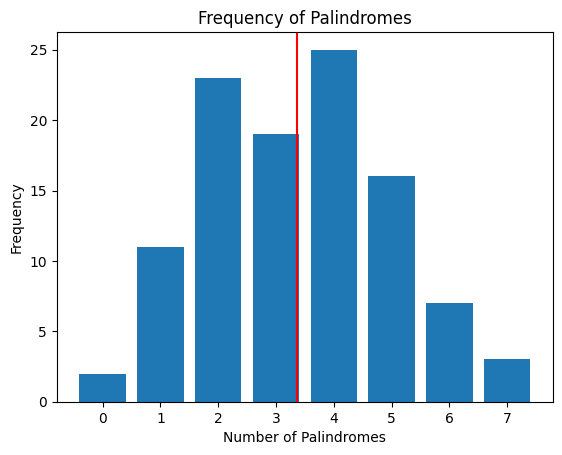

In [21]:
mean_pal = np.mean(arr_palindromes)

# Get the unique values and their counts
values, counts = np.unique(arr_palindromes, return_counts=True)

# Plot the frequency of numbers
plt.bar(values, counts)
plt.xlabel('Number of Palindromes')
plt.ylabel('Frequency')
plt.title('Frequency of Palindromes')
plt.axvline(x=mean_pal, color='red')

plt.show()

The figure above has a very close Gaussian distribution when observing the frequency of palindromes.

#### What is the probability that there are 10 palindromes detected within the first 10 DNA sequences? <br>What about the probability of 3 palindromes within the first 10 DNA sequences?

In [22]:
import math
P_10_palindromes = ( np.exp(-mean_pal*10) * (mean_pal*10)**10 ) / math.factorial(10)
print('P(N(10) = 10) =', P_10_palindromes)
P_3_palindromes = ( np.exp(-mean_pal*10) * (mean_pal*10)**3 ) / math.factorial(3)
print('P(N(10) = 3) =', P_3_palindromes)

P(N(10) = 10) = 1.222221993695921e-06
P(N(10) = 3) = 1.5039223762689678e-11


Using the assumption of Compound Poisson Distribution:<br>
$\lambda = w \theta^L$
<br>w is the window length.
<br>$\theta = 2 \cdot (p_A \cdot p_T + p_C \cdot p_G)$
<br>L is minimal palindrome length

In [23]:
steady_state_seqs = [0.261, 0.228, 0.229, 0.282]
theta = 2* ( steady_state_seqs[0]*steady_state_seqs[1] + steady_state_seqs[2]*steady_state_seqs[3] )
lamb = 4*theta**2
print('Using the Compound Poisson Distribution, lambda is calculated to be', round(lamb, 3))

# http://www.math.utep.edu/faculty/mleung/presentation/Leung-JMM100115Slides.pdf

Using the Compound Poisson Distribution, lambda is calculated to be 0.246


The Compound Poisson Distribution was used to compare the calculated lambda from the Compound Poisson Distribution to the calculated lambda from the histogram. It is clearly shown that there is a very large difference between the two values which shows how important it is to make correct assumptions for your model. I used the simple mean of the counts of palindromes of each sequence which worked well for my model.

# Brownian Motion

### This Brownian motion simulator below simulates the time it takes to detect the first occurrence of a value using Arbitrage Theorem.
The simulation can be applied to many applications where you want to find how long it takes for an even to occur.

Geometric Brownian Motion
$S_t=S_0\exp\bigg((r-\frac{1}{2}\sigma^2)t+\sigma\sqrt{t}z\bigg)$
<br>$\mu$ = drift rate
<br>$\sigma$ = volatility
<br>$Z=${$Z_t:t∈[0,∞)$}  is standard Brownian motion and $\mu \in \mathbb{R}$ and σ∈(0,∞).

In [24]:
import numpy as np
from scipy.stats import norm


def brownian_motion_hit_time(hit, mu=1, sigma=1, dt=0.01, t_max=100):
    """
    This function models a Brownian motion process that returns the time unitl a value
    is hit using the Arbitrage Theorem.
    dt is the time steps.
    hit is the value to find.
    """
    
    # Initialize the Brownian motion process
    t = np.arange(0, t_max+dt, dt)
    z = norm.rvs(size=len(t), scale=np.sqrt(dt))
    cumsum = np.cumsum((mu-0.5*sigma**2)*dt + sigma*z)
    
    # Find the first time the process hits the value: hit
    hit_indices = np.where(np.abs(cumsum - hit) <= np.sqrt(dt))[0]
    if len(hit_indices) > 0:
        hit_time = t[hit_indices[0]]
    else:
        hit_time = np.nan
    
    return hit_time

time = brownian_motion_hit_time(5)
print('It took', time, 'time units to find the value 5.')

It took 7.44 time units to find the value 5.
